#  SETUP


In [1]:
%%capture
!pip install xarray
!pip install netcdf4
!pip install collections
!pip install scikit-image
!pip install pysteps
!pip install cartopy
!pip install pysteps

In [2]:
import os
new_directory = '/dss/dsshome1/0D/ge74xuf2/climate_diffusion'
os.chdir(new_directory)
os.getcwd()

'/dss/dsshome1/0D/ge74xuf2/climate_diffusion'

In [3]:
from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.ticker as ticker
from scipy.stats import wasserstein_distance


import os
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr
import IPython.display as display
import logging
import torch.nn.functional as F
import collections
import copy


from torch import optim
from PIL import Image
from torch.utils import data
from torchvision import datasets, transforms
from functools import partial
from abc import abstractmethod
from skimage.transform import rescale


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as ticker


from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from skimage.metrics import structural_similarity as ssim

from src.utils import *
from src.utils_essential import *


from src.dataloader_sr import gfdl_eval_256, era5_upscaled_1d_256, era5_0_25d_256, SR_BC_GFDL_Dataset_256

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



In [4]:
bs_valid = 1400

In [5]:
era5_hr_ds = era5_0_25d_256(stage='valid')
era5_hr_dl = data.DataLoader(era5_hr_ds, batch_size=bs_valid, shuffle=False, drop_last=True)

era5_hr = next(iter(era5_hr_dl)).cpu()
era5_hr = era5_hr_ds.inverse_dwd_trafo(era5_hr)
print("HR ERA5", era5_hr.shape)

HR ERA5 torch.Size([1400, 1, 256, 256])


In [6]:
sr_gfdl_ds = SR_BC_GFDL_Dataset_256('data/100_gfdl_sr_imagen_e100_6_09.pth') 
sr_gfdl_dl = data.DataLoader(sr_gfdl_ds, batch_size=bs_valid,shuffle=False, drop_last=True)

dm_sr_gfdl = next(iter(sr_gfdl_dl)).cpu()
dm_sr_gfdl = era5_hr_ds.inverse_dwd_trafo(dm_sr_gfdl)

print("SR GFDL:",dm_sr_gfdl.shape)

/dss/dsshome1/0D/ge74xuf2/climate_diffusion/src/dataloader_sr.py:790: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.hr_bc_gfdl = torch.load(self.path)


dataset size torch.Size([1400, 1, 256, 256])
SR GFDL: torch.Size([1400, 1, 256, 256])


In [7]:
qm_first = False

if qm_first == True:
    qm_gfdl_ds = QM_GFDL_LR_Dataset_256('data/11_01_deltaQM_debiased_gfdl_valid_custom_dl.pth' ) 
    print("Benchmarked QM + Ups:")
if qm_first == False:
    qm_gfdl_ds = SR_BC_GFDL_Dataset_256('data/QM_hr_debiased_gfdl_valid_clip_0.pth') 
    print("Benchmarked Ups + QM:")

qm_gfdl_dl = data.DataLoader(qm_gfdl_ds, batch_size=bs_valid,shuffle=False, drop_last=True)

qm_gfdl = next(iter(qm_gfdl_dl)).cpu().unsqueeze(1)
print(qm_gfdl.shape)

dataset size torch.Size([1400, 256, 256])
Benchmarked Ups + QM:
torch.Size([1400, 1, 256, 256])


In [8]:
gfdl_256_ds = gfdl_eval_256(stage='valid')
gfdl_256_dl = data.DataLoader(gfdl_256_ds, batch_size=bs_valid, shuffle=False, drop_last=True)

gfdl_256 = next(iter(gfdl_256_dl))
gfdl_256 = gfdl_256_ds.inverse_dwd_trafo(gfdl_256)
print("HR original GFDL", gfdl_256.shape)

HR original GFDL torch.Size([1400, 1, 256, 256])


In [9]:
cm_path = "data/cm_precip_south_america_2011_2014.nc"
cm = xr.open_dataset(cm_path, cache=True, chunks=None)
cm_sr = torch.tensor(cm.precipitation.values).unsqueeze(1)
cm_sr.shape

torch.Size([1400, 1, 256, 256])

#  Evaluate sr-bc gfdl

# Plot absolute errors gfdl

In [12]:
#### bias in time + average bias in time (averaged over space) ####   x->256x256(t bias) -> 1 (avg t bias)

avg_sr_gfdl = torch.mean(dm_sr_gfdl.squeeze(1), axis=0)
avg_era5 = torch.mean(era5_hr.squeeze(1), axis=0)
avg_gfdl = torch.mean(gfdl_256.squeeze(1), axis=0)
avg_cm = torch.mean(cm_sr.squeeze(1), axis=0)


mean_bias_dm_gfdl = round(torch.mean(torch.abs(avg_era5 - avg_sr_gfdl)).item(), 2)
print("Mean bias DM-corrected GFDL",mean_bias_dm_gfdl)
mean_bias_gfdl = round(torch.mean(torch.abs(avg_era5 - avg_gfdl)).item(), 2)
print("Mean bias GFDL",mean_bias_gfdl)
mean_bias_cm_gfdl = round(torch.mean(torch.abs(avg_era5 - avg_cm)).item(), 2)
print("Mean bias CM",mean_bias_cm_gfdl)

Mean bias DM-corrected GFDL 0.29
Mean bias GFDL 0.69
Mean bias CM 0.31


Saving to figures_paper/climatologies_CM.pdf


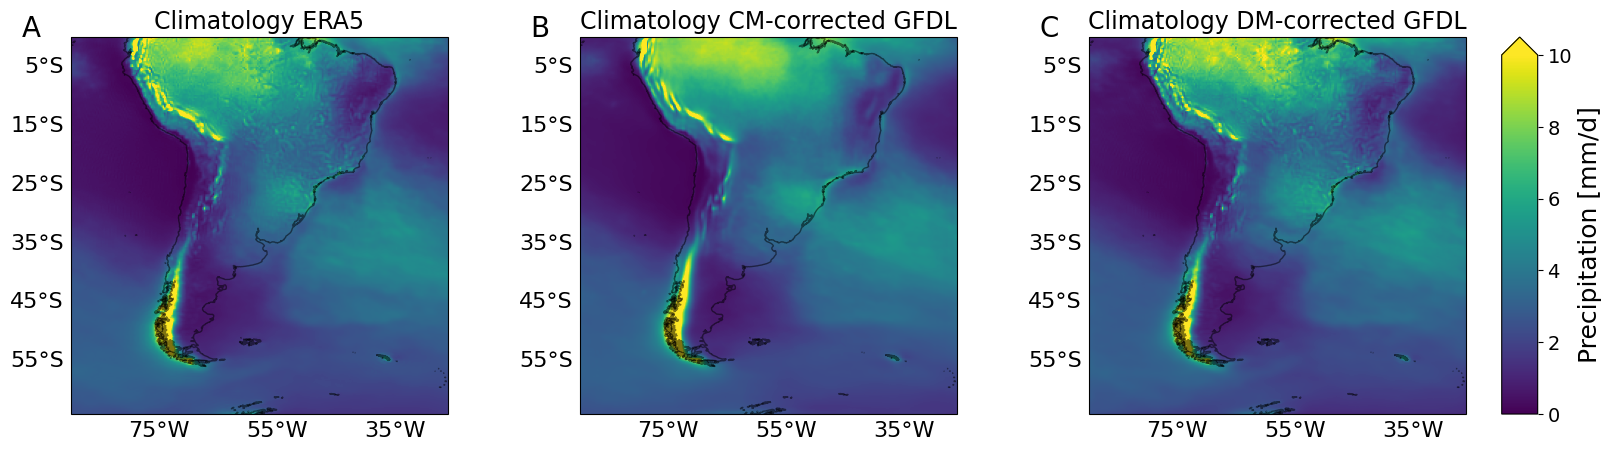

In [29]:
def plot_precipitation(ax, data, title, max_value=3):
    cmap = 'viridis'
    norm = plt.Normalize(vmin=0, vmax=max_value)
    img = ax.imshow(data, cmap=cmap, norm=norm, extent=[-90, -26, -64, 0])
    ax.coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.set_title(title)
    return img

latitudes = np.arange(-90, -26, 0.25)
longitudes = np.arange(0, -64, -0.25)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 18), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.35, hspace=0.25)

max_value = 10

img1 = plot_precipitation(axes[0], avg_era5 , "", max_value)
axes[0].text(-0.13, 1.06, 'A', transform=axes[0].transAxes, fontsize=20, fontweight='light', va='top')
axes[0].set_title(f'Climatology ERA5', fontsize=17)

img2 = plot_precipitation(axes[1], avg_cm, "", max_value)
axes[1].text(-0.13, 1.06, 'B', transform=axes[1].transAxes, fontsize=20, fontweight='light', va='top')
axes[1].set_title(f'Climatology CM-corrected GFDL', fontsize=17)

img3 = plot_precipitation(axes[2], avg_sr_gfdl, "", max_value)
axes[2].text(-0.13, 1.06, 'C', transform=axes[2].transAxes, fontsize=20, fontweight='light', va='top')
axes[2].set_title(f'Climatology DM-corrected GFDL', fontsize=17)

for ax in axes:
    ax.set_extent([-90, -26, -64, 0], crs=ccrs.PlateCarree())  
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = ticker.FixedLocator([-35, -45, -55, -65, -75, -85])  
    gl.ylocator = ticker.FixedLocator([-5, -15, -25, -35, -45, -55, -65])
    gl.xlabel_style = {'size': 16}  
    gl.ylabel_style = {'size': 16}

# Calculate the height of the colorbar based on the height of the axes
bbox = axes[0].get_position()
colorbar_height = bbox.height

cbar_ax = fig.add_axes([0.92, bbox.y0, 0.02, colorbar_height])  # Center the colorbar vertically and set its size
cbar = fig.colorbar(img1, cax=cbar_ax, extend="max", orientation="vertical")
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Precipitation [mm/d]' , fontsize=18)

save_figu = False
if save_figu == True:
    #plt.savefig("figures_paper/climatologies_CM.pdf", dpi=1000,bbox_inches='tight')
    print("Saving to figures_paper/climatologies_CM.pdf")
plt.show()

In [37]:
avg_gfdl.shape

torch.Size([256, 256])

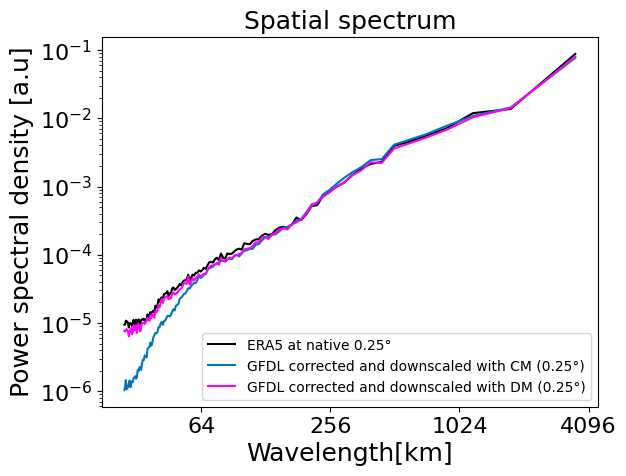

In [41]:
ssd = SpatialSpectralDensity_3_diff_res( avg_era5.unsqueeze(1).unsqueeze(1).numpy()
                                        ,avg_cm.unsqueeze(1).unsqueeze(1).numpy()
                                        ,avg_sr_gfdl.unsqueeze(1).unsqueeze(1).numpy()
                                      ,new_labels=['ERA5 at native 0.25°',
                                                   "GFDL corrected and downscaled with CM (0.25°)",
                                                   'GFDL corrected and downscaled with DM (0.25°)']
                                      ,y_ax_name='Power spectral density [a.u]',x_ax_name=r'Wavelength[km]',
                                       title="Spatial spectrum")
ssd.run(num_times=None)
ssd.plot_psd(model_resolution=0.25, model_resolution_2=0.25
             ,do_savefig=False
             #,do_savefig="figures_paper/CM_PSD.pdf"
             ,plt_legend=True)

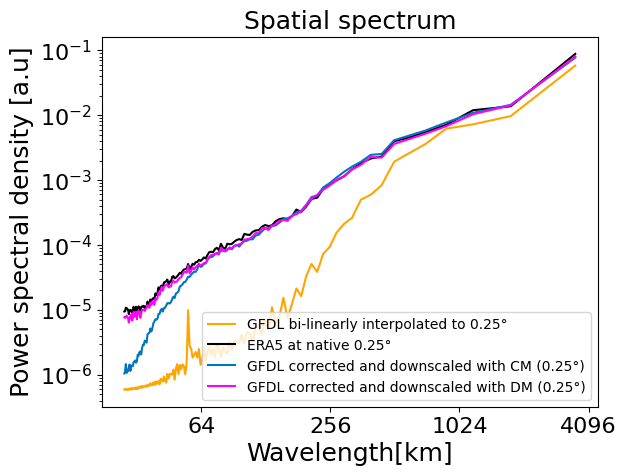

In [17]:
ssd = SpatialSpectralDensity_4_diff_res( avg_gfdl.unsqueeze(1).unsqueeze(1).numpy()
                                      ,avg_era5.unsqueeze(1).unsqueeze(1).numpy()
                                      ,avg_cm.unsqueeze(1).unsqueeze(1).numpy()
                                      ,avg_sr_gfdl.unsqueeze(1).unsqueeze(1).numpy()
                                      ,new_labels=['GFDL bi-linearly interpolated to 0.25°',
                                                   'ERA5 at native 0.25°',
                                                   "GFDL corrected and downscaled with CM (0.25°)",
                                                   'GFDL corrected and downscaled with DM (0.25°)']
                                      ,y_ax_name='Power spectral density [a.u]',x_ax_name=r'Wavelength[km]',
                                       title="Spatial spectrum")
ssd.run(num_times=None)
ssd.plot_psd(model_resolution=0.25, model_resolution_2=0.25, do_savefig=False,plt_legend=True)